In [1]:
import wntr

import matplotlib.pyplot as plt
import wntr.graphics.network as wntr_graphics

In [2]:
# Load network
#wn = wntr.network.WaterNetworkModel('data/Net1_EPANET-EXAMPLE_1s.inp') - works on my system
wn = wntr.network.WaterNetworkModel('data/Net3_EPANET-EXAMPLE_No_Demand_Change.inp')

#wn = wntr.network.WaterNetworkModel('data/Net3_EPANET-EXAMPLE.inp') - does not work on my system
#wn = wntr.network.WaterNetworkModel('data/Micropolis_TEVA-SPOT_Adjusted_PumpCurve3&4.inp')
#wn = wntr.network.WaterNetworkModel('data/Net3_(BWSN-2)_Morph_Error_Free_1s-WQ.inp')

# Run simulation
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
print("Simulation complete!")

Simulation complete!


In [3]:
# Get list of nodes and links
print("Nodes:", wn.node_name_list[:10])
print("Links:", wn.link_name_list[:10])

# Example: pressures at all nodes (in meters of head)
pressure = results.node['pressure']

# Look at the first few timesteps
pressure.head()


Nodes: ['10', '15', '20', '35', '40', '50', '60', '601', '61', '101']
Links: ['20', '40', '50', '60', '101', '103', '105', '107', '109', '111']


name,10,15,20,35,40,50,60,601,61,101,...,267,269,271,273,275,River,Lake,1,2,3
0,-0.174092,28.545839,8.839199,40.542843,3.992880,7.162800,63.663086,91.898102,91.898102,31.829906,...,38.219528,44.612568,42.552387,40.485798,39.669624,0.0,0.0,3.992880,7.162800,8.839199
3600,-0.062931,28.681910,8.993134,40.652149,4.158386,6.872975,63.669914,91.943657,91.943657,31.941069,...,38.327930,44.719654,42.660095,40.525455,39.696297,0.0,0.0,4.158386,6.872975,8.993134
7200,0.047081,28.814392,9.141540,40.758785,4.289490,6.724143,63.676575,91.988091,91.988091,32.051079,...,38.435318,44.825863,42.765919,40.588326,39.753468,0.0,0.0,4.289490,6.724143,9.141535
10800,0.155874,28.943449,9.284889,40.863327,4.402883,6.663337,63.683067,92.031479,92.031479,32.159874,...,38.541653,44.931103,42.870136,40.666588,39.829449,0.0,0.0,4.402883,6.663337,9.284884
14400,0.264193,29.069525,9.423593,40.967365,4.509267,6.655691,63.689415,92.073936,92.073936,32.268192,...,38.647770,45.036251,42.974075,40.753967,39.915688,0.0,0.0,4.509267,6.655691,9.423593


In [4]:
print(results.node['pressure'].index)


Index([    0,  3600,  7200, 10800, 14400, 18000, 21600, 25200, 28800, 32400,
       36000, 39600, 43200, 46800, 50400, 54000, 57600, 61200, 64800, 68400,
       72000, 75600, 79200, 82800, 86400],
      dtype='int32')


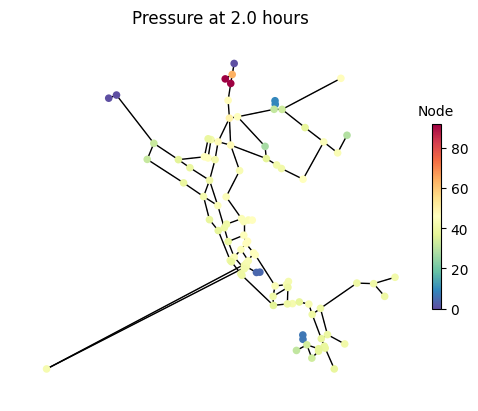

In [5]:


# Select one timestep (e.g. 2 hours = 7200 seconds)
t = 7200

# Plot the network colored by pressure
wntr_graphics.plot_network(
    wn, 
    node_attribute=pressure.loc[t, :],
    node_size=30,
    title=f"Pressure at {t/3600:.1f} hours"
)
plt.show()


In [6]:
wn.pump_name_list

['10', '335']

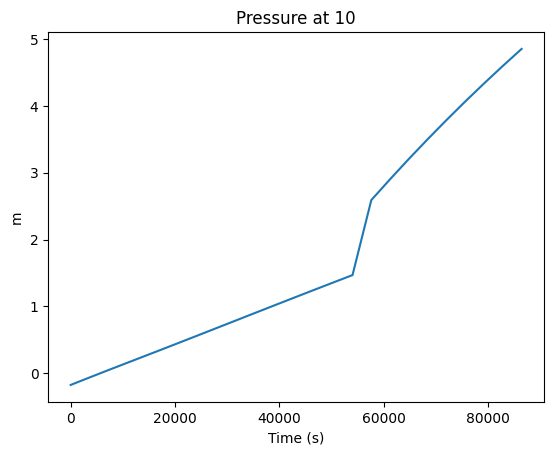

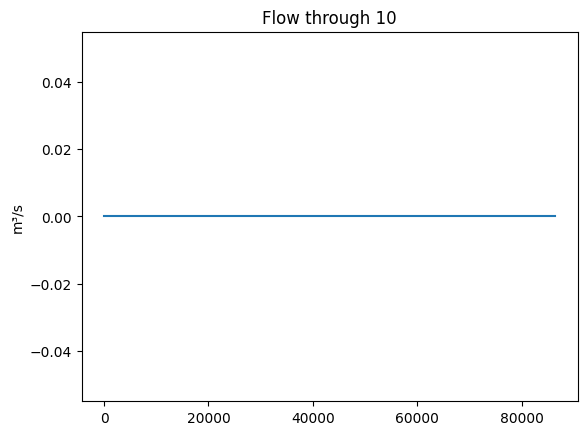

In [7]:
# Plot pressure at one node through time
node_name = wn.junction_name_list[0]
pressure[node_name].plot(title=f"Pressure at {node_name}", ylabel='m', xlabel='Time (s)')
plt.show()

# Energy usage or flow data
flow = results.link['flowrate']
pump_name = [p for p in wn.pump_name_list][0]
flow[pump_name].plot(title=f"Flow through {pump_name}", ylabel='m³/s')
plt.show()
